# Flower Species Detection

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



### Installing PyTorch at Google Colab

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58646000 @  0x7fdeeebef2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1
    100% |████████████████████████████████| 2.0MB 16.5MB/s 
  [PIL]
You must restart the runtime in order to use newly installed versions.
4.0.0


### Importing Libraries

In [0]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import seaborn as sns
from torch import optim
torch.__version__

'0.4.1'

## Load the data

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
classes = os.listdir(valid_dir)
print(classes)

['18', '67', '62', '68', '28', '87', '7', '29', '96', '56', '94', '66', '89', '27', '59', '90', '30', '34', '69', '36', '95', '22', '15', '9', '75', '81', '45', '65', '17', '88', '52', '47', '25', '58', '13', '32', '91', '51', '92', '55', '4', '31', '64', '102', '86', '100', '10', '44', '74', '99', '71', '19', '21', '49', '79', '24', '46', '6', '76', '5', '38', '39', '11', '12', '77', '70', '60', '57', '26', '43', '54', '78', '82', '1', '37', '97', '23', '73', '101', '40', '2', '42', '50', '85', '48', '8', '35', '72', '16', '93', '98', '3', '33', '20', '14', '83', '41', '53', '61', '84', '80', '63']


Class Directory:  92


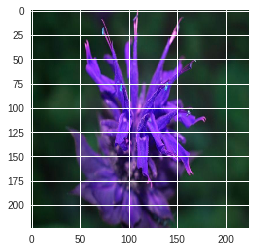

(224, 224, 3)


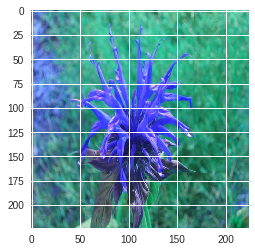

(224, 224, 3)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(train_dir, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(train_dir, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

In [0]:
def get_batch_data(batch_size):
  
  train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                         transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                                         transforms.RandomHorizontalFlip(),
                                         torchvision.transforms.ColorJitter(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

  test_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])
  train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
  test_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
  num_workers = 0

  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                             num_workers=num_workers, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=num_workers)
  return train_loader, test_loader, train_data, test_data


In [0]:
train_loader, test_loader, train_data, test_data = get_batch_data(batch_size = 32)
# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

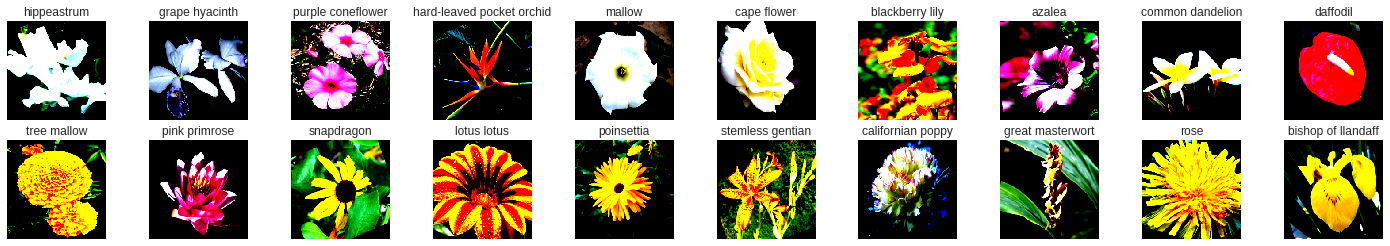

In [0]:
## Showing the training images
dataiter = iter(train_loader)
imgs, labels = next(dataiter)
imgs = imgs.numpy() 
imgs = np.clip(imgs, 0, 1)


fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    ax.set_title(cat_to_name[classes[labels[i]]])

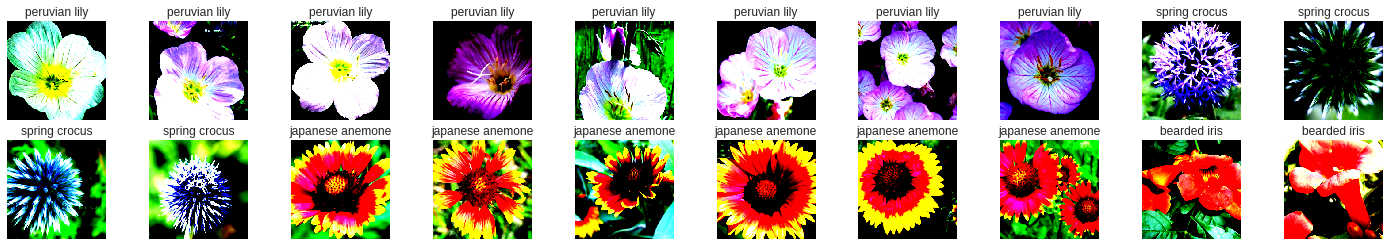

In [0]:
# Showing the validation images
dataiter = iter(test_loader)
imgs, labels = next(dataiter)
imgs = imgs.numpy() 
imgs = np.clip(imgs, 0, 1)


fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    ax.set_title(cat_to_name[classes[labels[i]]])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.


In [0]:
model = models.resnet152(pretrained=True)

In [0]:
model

### Freezing the model layers

In [0]:
for i, param in enumerate(model.parameters()):
    if i==99:
      param.requires_grad = True
    else:
      param.requires_grad = False

### Defining My Classifier

In [0]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, len(classes))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# Moving the model to GPU if available
model.to(device)

In [0]:
from torch import optim

# Defining loss function
criterion = nn.NLLLoss()
# Defining optimizer and using adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Defining the scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.12)

### Training The Classifier 

In [0]:
epochs = 27
running_loss = 0
valid_loss_min = np.Inf 
accuracy = 0
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
for e in range(epochs):
  running_loss = 0
  steps = 0
  total = 0
  scheduler.step()
  accuracy = 0
  for images, labels in train_loader:
    steps+=1
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*images.size(0)
  
  total = 0
  valid_loss = 0
  correct_predictions = 0
  running_loss = running_loss / len(train_loader.dataset)
  train_loss_list.append(running_loss)
  model.eval()
  for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()*images.size(0)
        predictions = torch.max(outputs, 1)[1]
        correct_predictions += torch.sum(predictions == labels.data)

  valid_loss = valid_loss / len(test_loader.dataset)
  accuracy = correct_predictions.double() / len(test_loader.dataset)
        
  print("Epochs : {}/{}".format(e+1,epochs),
            "Training Loss : {:.3f}".format(running_loss),
            "Test Loss : {:.3f}".format(valid_loss),
             "Accuracy : {:.3f}".format(accuracy))
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss
  running_loss = 0
  model.train()


In [0]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
model.state_dict()

In [0]:
# Saving the Model check point to google drive
model_save_name = 'flowers_classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
## torch.save(model.state_dict(), path)

In [0]:
# Loading the check point
model.load_state_dict(torch.load('model.pt'))

In [0]:
train_loader, test_loader, train_data, test_data = get_batch_data(batch_size = 16)
# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


## Training the whole model with all the layers unfreezed

In [0]:
# Unfreezing the layers parameters
for i, param in enumerate(model.parameters()):
      param.requires_grad = True
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
epochs = 16
model.to(device)
running_loss = 0
valid_loss_min = np.Inf 
accuracy = 0
model.train()
for e in range(epochs):
  running_loss = 0
  steps = 0
  correct_predictions = 0
  total = 0
  scheduler.step()
  accuracy = 0
  for images, labels in train_loader:
    steps+=1
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()*images.size(0)
  
  total = 0
  valid_loss = 0
  running_loss = running_loss / len(train_loader.dataset)
  model.eval()
  for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()*images.size(0)
        predictions = torch.max(outputs, 1)[1]
        correct_predictions += torch.sum(predictions == labels.data)

  valid_loss = valid_loss / len(test_loader.dataset)
  accuracy = correct_predictions.double() / len(test_loader.dataset)
        
  print("Epochs : {}/{}".format(e+1,epochs),
            "Training Loss : {:.3f}".format(running_loss),
            "Test Loss : {:.3f}".format(valid_loss),
             "Accuracy : {:.3f}".format(accuracy))
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(), 'model1.pt')
    valid_loss_min = valid_loss
  running_loss = 0
  model.train()

### Loading The Check Point

In [0]:
model_save_name = 'flowers_classifier2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

In [0]:
# Loading the new check point to google drive
# model.load_state_dict(torch.load(path))
model.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage),strict=False)

In [0]:
model

In [0]:
model.state_dict()

## Save the checkpoint


```model.class_to_idx = image_datasets['train'].class_to_idx```

In [0]:
model_file_name = 'classifier.pth'
model.class_to_idx = train_data.class_to_idx
model.cpu()
torch.save({'arch': 'resnet152',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx},
             model_file_name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
def model_load(CheckPoint_path):
  # loading checkpoint
  checkpoint = torch.load(CheckPoint_path)
  # getting pretrained network of the same network we trained
  pretrained = getattr(models, checkpoint['arch'])
  # Check if the architecture name saved is right
  if callable(pretrained):
    model = pretrained(pretrained=True)
    # Freeze all the pretrained model layers
    for param in model.parameters():
      param.requires_grad = False
  else:
    print('Architecture not recognized!!')
  
  model.class_to_idx = checkpoint['class_to_idx']
  
  # Classifier 
  classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, len(classes))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
  # Appending my classifier to the model classifier  
  model.fc = classifier
  # loading the pretrained state 
  model.load_state_dict(checkpoint['state_dict'])

  return model  

In [0]:
# Loading the model 
model = model_load('classifier.pth')

In [0]:
model.state_dict()

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 




As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. 

In [0]:
from PIL import Image
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)
    width = img.size[0]
    height = img.size[1]

    # Resizing the image for the network
    img.thumbnail((500, 256) if (width > height) else (256, 500))  

    
    # Cropping the image
    left = (img.width-224)/2
    top = (img.height-224)/2
    right = left + 224
    bottom = top + 224
    
    img = img.crop((left, top, right, bottom))
    
    # Normalize the image
    img = np.asarray(img)/255
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.485, 0.456, 0.406])
    img = (img - mean)/std
    
    # Color channel as first channel for PyTorch
    img = img.transpose((2, 0, 1))
    
    return img
  

To check the work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

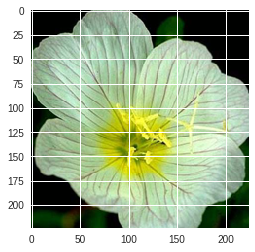

In [0]:
# Test processing and showing functions
image_path = valid_dir+'/1/image_06739.jpg'
img = process_image(image_path)
imshow(img)

## Class Prediction


In [0]:
def predict(image_path, model, topk=5):
    # Processing image
    img = process_image(image_path)
    
    # Change img type to tensor
    img = torch.from_numpy(img).type(torch.FloatTensor)
    # Add Batch size of 1 to img
    input_img = img.unsqueeze(0)
    
    # Move the model and the input to cpu
    input_img.to('cpu')
    model.to('cpu')
    img.to('cpu')
    
    # Get top 5 predictions
    probabilities = torch.exp(model.forward(input_img))
    top_probs, top_classes = probabilities.topk(5)
    
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_classes = top_classes.detach().numpy().tolist()[0]
    
    # index to class mapper
    idx_to_class = {class_idx: idx for idx, class_idx in model.class_to_idx.items()}
    # Computing the top 5 flowers species
    top_targets = [idx_to_class[target] for target in top_classes]
    top_species = [cat_to_name[idx_to_class[target]] for target in top_classes]
    
    return top_species, top_targets, top_probs

## Sanity Checking

In [0]:
def plot_output(image_path, model):
  # Plot 
  plt.figure(figsize=(7, 11))
  ax = plt.subplot(2, 1, 1)
  # Titles
  number = image_path.split('/')[2]
  title = cat_to_name[number]
  # Plotting the flower
  img = process_image(image_path)
  imshow(img, ax, title)
  # Predictions
  species, labels, probs = predict(image_path, model)
  # Plot bar graph
  plt.subplot(2, 1, 2)
  sns.barplot(x=probs, y=species, color=sns.color_palette()[0])
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


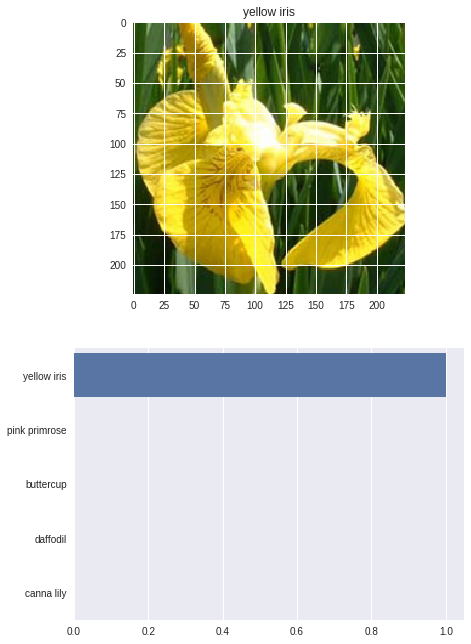

In [0]:
img_path = valid_dir+'/15/image_06346.jpg'
plot_output(img_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


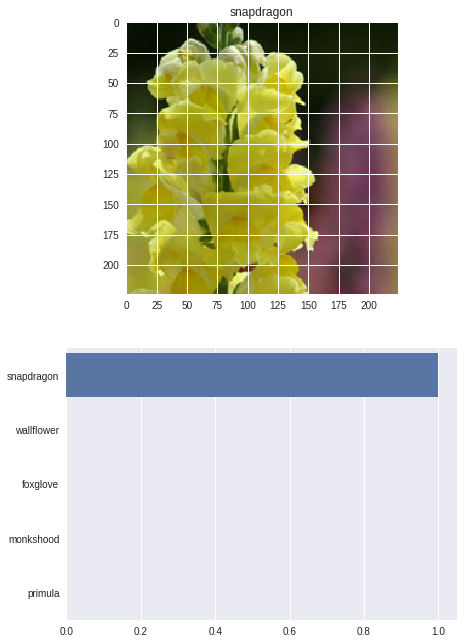

In [0]:
img_path = valid_dir+'/11/image_03100.jpg'
plot_output(img_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


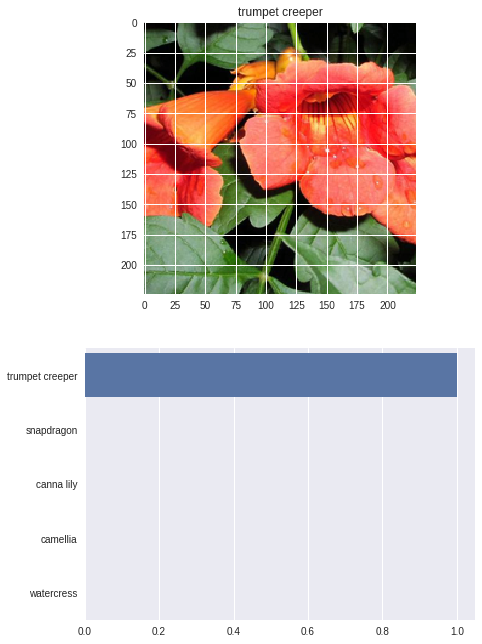

In [0]:
img_path = valid_dir+'/101/image_07951.jpg'
plot_output(img_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


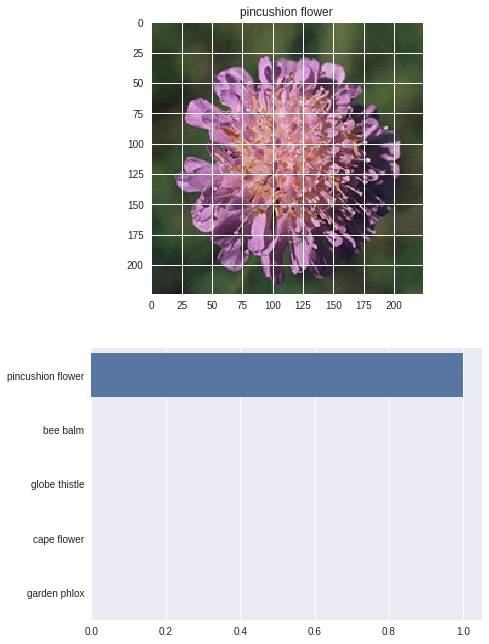

In [0]:
img_path = valid_dir+'/22/image_05352.jpg'
plot_output(img_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


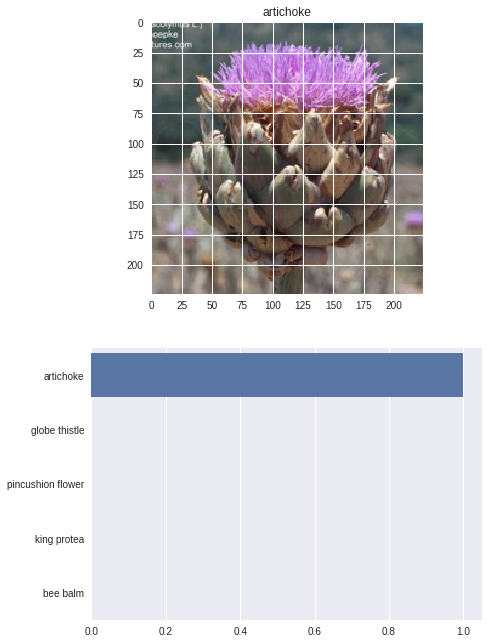

In [0]:
img_path = valid_dir+'/29/image_04097.jpg'
plot_output(img_path, model)

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)